In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

In [12]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  
import colors as s

In [13]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(folder)

2.154434690031884
Eff_area_PKSflare_crab_cutoff


In [14]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.24 s, sys: 186 ms, total: 6.43 s
Wall time: 6.44 s


In [15]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)


In [17]:
dataset_asimov_N.exposure.unit

Unit("m2 s")

bias 0.0 idx 0
bias 0.0 idx 0
bias 0.0 idx 0


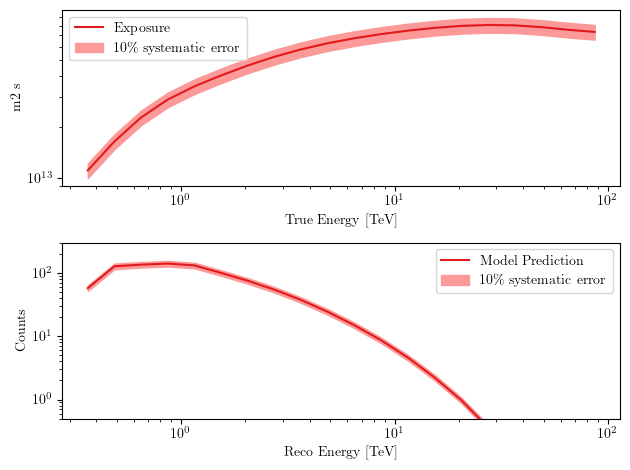

In [41]:
fig,axs = plt.subplots(2,1)
ax = axs[0]
emask = dataset_asimov_N.mask.data.sum(axis=2).sum(axis=1) >0 

e_bins = dataset_asimov_N.geoms['geom'].axes[0].center.value[emask]

true_energy = dataset_asimov_N.exposure.geom.axes[0].center.value[emask]
ax.plot(e_bins,sum_e(dataset_asimov_N.npred_exposure().data ), color = s.red,
        label = "Exposure")
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)[emask]
dataset_asimov_N.irf_model.parameters['norm'].value = -0.1
neg = sum_e(dataset_asimov_N.npred_exposure().data )

dataset_asimov_N.irf_model.parameters['norm'].value = 0.1
pos = sum_e(dataset_asimov_N.npred_exposure().data )

ax.fill_between(e_bins,neg, pos, label = '$10 \%$ systematic error', color = s.lred)
dataset_asimov_N.irf_model.parameters['norm'].value = 0.

ax.set_ylabel(dataset_asimov_N.exposure.unit)
ax.set_xlabel("True Energy [TeV]")
ax.legend()
ax.loglog()


ax=axs[1]
ax.plot(e_bins,sum_e(dataset_asimov_N.npred_signal().data ), color = s.red,
        label = "Model Prediction")
def sum_e2(x):
    ee = x.sum(axis=2).sum(axis=1)[emask]
    return ee
dataset_asimov_N.irf_model.parameters['norm'].value = -0.1
neg = sum_e(dataset_asimov_N.npred_signal().data )

dataset_asimov_N.irf_model.parameters['norm'].value = 0.1
pos = sum_e(dataset_asimov_N.npred_signal().data )

ax.fill_between(e_bins,neg, pos, label = '$10 \%$ systematic error', color = s.lred)
dataset_asimov_N.irf_model.parameters['norm'].value = 0.

ax.set_ylim(0.5, 300)
ax.set_ylabel("Counts")
ax.set_xlabel("Reco Energy [TeV]")
ax.legend()
ax.loglog()
plt.tight_layout()
fig.savefig("plots/1_eff_area_exposure_npred.pdf")